<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_12_Weights_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import copy

import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Weight Freezing

In [2]:
# Import the small MNIST dataset that comes with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"),delimiter=",")

# Extract the labels and remove them from data
labels = data[:,0]
data = data[:,1:]

# Normalize data on range 0-1
dataNorm = data/np.max(data)

In [3]:
# Convert the data into tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Split
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into dataLoader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [7]:
# Create the architecture class
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32,10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)

    # Create an instance
    net = mnistNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

## Brief Inspection of requires_grad

In [11]:
# See how to toggle the learning of a layer
N = createTheMNISTNet()[0]
print(N.fc1)
print(N.fc1.weight) # check requires_grad=True
print(N.fc1.weight.detach())  # removes requires_grad
N.fc1.weight.requires_grad  # default is True

Linear(in_features=64, out_features=32, bias=True)
Parameter containing:
tensor([[-0.0307,  0.0256, -0.1097,  ...,  0.0451, -0.1163, -0.0009],
        [ 0.0175,  0.0223, -0.0385,  ...,  0.0881,  0.1125, -0.1023],
        [-0.0795,  0.1092, -0.0834,  ..., -0.0742, -0.0905,  0.0681],
        ...,
        [ 0.0614,  0.0614, -0.1105,  ...,  0.0308, -0.1072,  0.1232],
        [-0.0441,  0.0923, -0.0718,  ..., -0.1105,  0.0954,  0.0857],
        [-0.0469,  0.1031,  0.0330,  ...,  0.0510, -0.0919,  0.1233]],
       requires_grad=True)
tensor([[-0.0307,  0.0256, -0.1097,  ...,  0.0451, -0.1163, -0.0009],
        [ 0.0175,  0.0223, -0.0385,  ...,  0.0881,  0.1125, -0.1023],
        [-0.0795,  0.1092, -0.0834,  ..., -0.0742, -0.0905,  0.0681],
        ...,
        [ 0.0614,  0.0614, -0.1105,  ...,  0.0308, -0.1072,  0.1232],
        [-0.0441,  0.0923, -0.0718,  ..., -0.1105,  0.0954,  0.0857],
        [-0.0469,  0.1031,  0.0330,  ...,  0.0510, -0.0919,  0.1233]])


True

In [13]:
N = createTheMNISTNet()[0]

# Switch off all the layers except input
for p in N.named_parameters():
    if "input" not in p[0]:
        p[1].requires_grad = False

# See what's going on
for p in N.named_parameters():
    print("Requires_grad status in layer %s: %s" %(p[0], p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


In [14]:
# Create a function to train the model
def function2trainTheModel(net, lossfun, optimizer):

    numepochs = 100

    # Initialize the losses
    losses = torch.zeros((numepochs, 2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch off learning in all but the output layers during half of the training
        if epochi < (numepochs/2):
            for p in net.named_parameters():
                if "output" not in p[0]:
                    p[1].requires_grad = False
        else:
            for p in net.named_parameters():
                p[1].requires_grad = True

        # Switch the training mode on
        net.train()

        # Loop over the batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy of each batch
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # End of the batch loop 
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad(): # deactivate autograd
            yHat = net(X)
        losses[epochi,1] = lossfun(yHat,y).item()
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    
    # End of epochs
    return trainAcc, testAcc, losses, net

In [15]:
# Get a new network instance
net, lossfun, optimizer = createTheMNISTNet()

# train the model
trainAcc, testAcc, losses, net = function2trainTheModel(net, lossfun, optimizer)

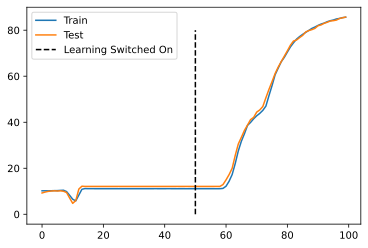

In [22]:
plt.plot(trainAcc, label="Train")
plt.plot(testAcc, label="Test")
plt.plot([len(trainAcc)/2, len(trainAcc)/2], [0, 80], "k--", label="Learning Switched On")
plt.legend()
plt.show()

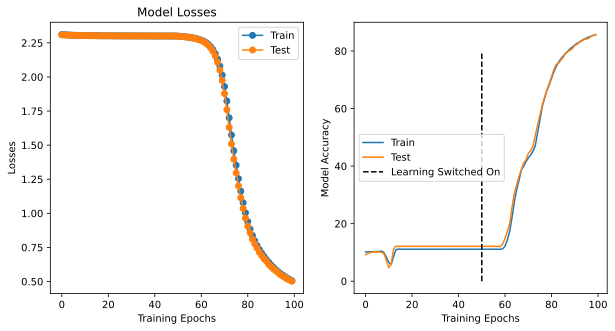

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses, "o-")
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Model Losses")
ax[0].legend(["Train", "Test"])

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].plot([len(trainAcc)/2, len(trainAcc)/2], [0, 80], "k--", label="Learning Switched On")
ax[1].set_ylabel("Model Accuracy")
ax[1].set_xlabel("Training Epochs")
ax[1].legend()

plt.show()

In [23]:
# Run the whole thing using Adam
# Create the architecture class
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32,10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)

    # Create an instance
    net = mnistNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [24]:
# Create a function to train the model
def function2trainTheModel(net, lossfun, optimizer):

    numepochs = 100

    # Initialize the losses
    losses = torch.zeros((numepochs, 2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch off learning in all but the output layers during half of the training
        if epochi < (numepochs/2):
            for p in net.named_parameters():
                if "output" not in p[0]:
                    p[1].requires_grad = False
        else:
            for p in net.named_parameters():
                p[1].requires_grad = True

        # Switch the training mode on
        net.train()

        # Loop over the batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy of each batch
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # End of the batch loop 
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad(): # deactivate autograd
            yHat = net(X)
        losses[epochi,1] = lossfun(yHat,y).item()
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    
    # End of epochs
    return trainAcc, testAcc, losses, net

In [25]:
# Get a new network instance
net, lossfun, optimizer = createTheMNISTNet()

# train the model
trainAcc, testAcc, losses, net = function2trainTheModel(net, lossfun, optimizer)

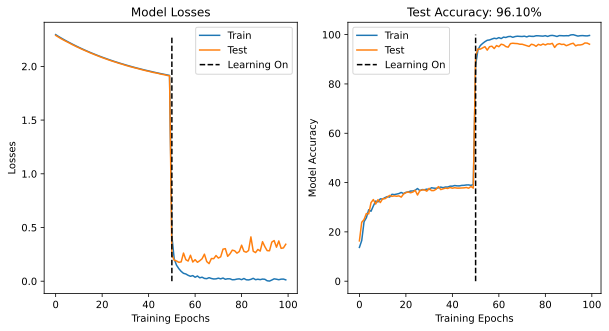

In [35]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")
ax[0].plot([len(losses)/2, len(losses)/2], [0, max(losses[1])], "k--")
ax[0].set_title("Model Losses")
ax[0].legend(["Train", "Test", "Learning On"])

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].plot([len(trainAcc)/2, len(trainAcc)/2], [0, 100], "k--", label="Learning On")
ax[1].set_ylabel("Model Accuracy")
ax[1].set_xlabel("Training Epochs")
ax[1].set_title(f"Test Accuracy: {testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()
# Adam just beats the shit out of it!

# Weight Changes

In [36]:
# We will use MNIST again, same model architecture but with SGD, Not Adam
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32,10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)

    # Create an instance
    net = mnistNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [37]:
# Create a function to train the model
def function2trainTheModel(net, lossfun, optimizer):

    numepochs = 100

    # Initialize the losses
    losses = torch.zeros((numepochs, 2))
    trainAcc = []
    testAcc = []

    # Initialize the weight changes
    weightChange = np.zeros((numepochs,4)) # Store Euclidean Distance Changes
    weightConds = np.zeros((numepochs,4)) # Store the condition numbers

    # Loop over the epochs
    for epochi in range(numepochs):

        # Store the weights of each layer
        preW = [] # grab all weights before training
        for p in net.named_parameters():
            if "weight" in p[0]:
                preW.append(copy.deepcopy(p[1].data.numpy())) # for using numpy's linear algebra functions

        # Switch the training mode on
        net.train()
        # Loop over the batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy of each batch
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # End of the batch loop 
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad(): # deactivate autograd
            yHat = net(X)
        losses[epochi,1] = lossfun(yHat,y).item()
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # Fetch post-learning state of the weights
        for (i,p) in enumerate(net.named_parameters()):
            if "weight" in p[0]:
                # condition number
                # To save data only for weights, we divide i/2
                weightConds[epochi,int(i/2)] = np.linalg.cond(p[1].data)

                # Frobenius Norm of the weight change from pre-learning
                weightChange[epochi,int(i/2)] = np.linalg.norm(preW[int(i/2)]-p[1].data.numpy(), ord="fro")
    
    # End of epochs
    return trainAcc, testAcc, losses, net, weightChange, weightConds, preW

In [38]:
# Run the thing
net, lossfun, optimizer = createTheMNISTNet()

# train it
trainAcc, testAcc, losses, net, weightChange, weightConds, preW = function2trainTheModel(net, lossfun, optimizer)

In [39]:
# Get a list of layer names
layerName = []
for (i,p) in enumerate(net.named_parameters()):
    if "weight" in p[0]:
        layerName.append(p[0][:-7])
print(layerName)

['input', 'fc1', 'fc2', 'output']


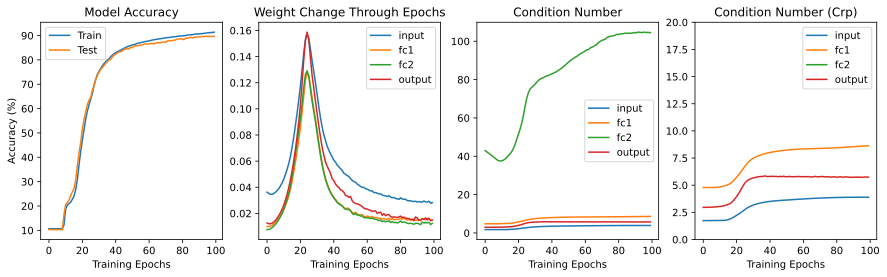

In [43]:
# Plot
fig,ax = plt.subplots(1,4, figsize=(15,4))

# Accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].legend(["Train", "Test"])

# Weight Changes
ax[1].plot(weightChange)
ax[1].set_xlabel("Training Epochs")
ax[1].set_title("Weight Change Through Epochs")
ax[1].legend(layerName)

# Weight Condition Number
ax[2].plot(weightConds)
ax[2].set_xlabel("Training Epochs")
ax[2].set_title("Condition Number")
ax[2].legend(layerName)

ax[3].plot(weightConds)
ax[3].set_xlabel("Training Epochs")
ax[3].set_title("Condition Number (Crp)")
ax[3].legend(layerName)
ax[3].set_ylim([0,20])

plt.show()

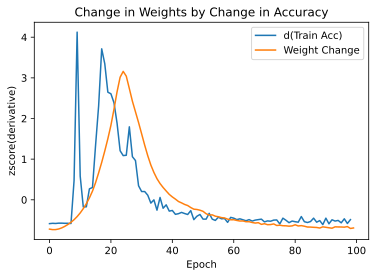

In [45]:
# Check the derivative of accuracy against weight change
from scipy.stats import zscore

plt.plot(zscore(np.diff(trainAcc)), label="d(Train Acc)")
plt.plot(zscore(np.mean(weightChange, axis=1)), label="Weight Change")
plt.legend()
plt.title("Change in Weights by Change in Accuracy")
plt.xlabel("Epoch")
plt.ylabel("zscore(derivative)")
plt.show()

# As the model learns, the weights are changing drastically, but they slow down with lerning